# Analysis of Dutch Election Polls #TK2021
*Source: Wikipedia*

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from highlight_text import fig_text
import custom_theme

## Data processing

In [2]:
results = pd.read_html('https://en.wikipedia.org/wiki/2021_Dutch_general_election')[3]
results = (results.filter(['Party', 'Current seats'])
                  .rename(columns={'Party': 'Partij', 'Current seats': 'Verkiezingen'})
                  .set_index('Partij')
                  .rename(index={'FvD': 'FVD', 'DENK': 'Denk'}))
results

,Verkiezingen
Partij,
VVD,32
PVV,20
CDA,19
D66,19
GL,14
SP,14
PvdA,9
CU,5
PvdD,4


In [3]:
polls = pd.read_html('https://nl.wikipedia.org/wiki/Tweede_Kamerverkiezingen_2021/Peilingen')[1]

# Clean DataFrame
polls = (polls
         .assign(
             Peilingorganisatie=lambda x: x['Peilingorganisatie'].replace(r'\[\d\]', '', regex=True).str.strip(),
             Datum=lambda x: pd.to_datetime(x['Datum'].str.replace('mrt', 'mar'))
             )
         .sort_values('Datum')
         .drop_duplicates(subset='Peilingorganisatie', keep='last')
         .drop(columns=['Datum'])
         .set_index(['Peilingorganisatie'])
         .transpose()
         .join(results).fillna(0).astype('int')
         .rename(columns={'Kantar Public / TNS NIPO': 'Kantar Public',
                           'Ipsos': 'EenVandaag'})
         .sort_values('Verkiezingen', ascending=False)
         [['Verkiezingen', 'EenVandaag', 'I&O Research', 'Peil.nl', 'Kantar Public']])

# Remove parties with no seats in any poll
polls = polls[polls.sum(axis=1) > 0]

# Rename "Andere" to "Splinter"
polls = polls.rename(index={'Andere': 'Splinter'})

polls

,Verkiezingen,EenVandaag,I&O Research,Peil.nl,Kantar Public
VVD,32,35,33,32,36
PVV,20,19,19,22,18
CDA,19,17,17,17,15
D66,19,19,19,19,17
GL,14,11,11,8,9
SP,14,11,10,11,12
PvdA,9,11,11,10,12
CU,5,6,6,6,6
PvdD,4,6,5,6,6
Denk,3,2,2,2,2


## Polling error

In [4]:
poll_names = ['EenVandaag', 'I&O Research', 'Peil.nl', 'Kantar Public']
errors = polls[poll_names].sub(polls['Verkiezingen'], axis=0)
errors

,EenVandaag,I&O Research,Peil.nl,Kantar Public
VVD,3,1,0,4
PVV,-1,-1,2,-2
CDA,-2,-2,-2,-4
D66,0,0,0,-2
GL,-3,-3,-6,-5
SP,-3,-4,-3,-2
PvdA,2,2,1,3
CU,1,1,1,1
PvdD,2,1,2,2
Denk,-1,-1,-1,-1


In [5]:
errors.median(axis=1).sort_values().to_frame('Zetels verschil (mediaan)').T

,GL,SP,50+,CDA,PVV,Denk,Splinter,D66,SGP,BIJ1,CU,BBB,JA21,VVD,PvdA,PvdD,FVD,Volt
Zetels verschil (mediaan),-4.0,-3.0,-2.5,-2.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0


In [6]:
np.abs(errors).sum(axis=0).sort_values().to_frame('Totaal zetelversil').T

,EenVandaag,I&O Research,Peil.nl,Kantar Public
Totaal zetelversil,29,29,33,39


## Visualization

In [7]:
def plot_logo(x, y, image, ax, zoom=1):
    '''Help function for plotting logos on ax'''
    image = plt.imread(image)
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def add_value_labels(ax):
    '''Help function for plotting value above bar'''
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        y_nudge = 1 if y_value >= 0 else -12

        ax.annotate(
            str(y_value),
            (x_value, y_value),
            xytext=(0, y_nudge),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=11)

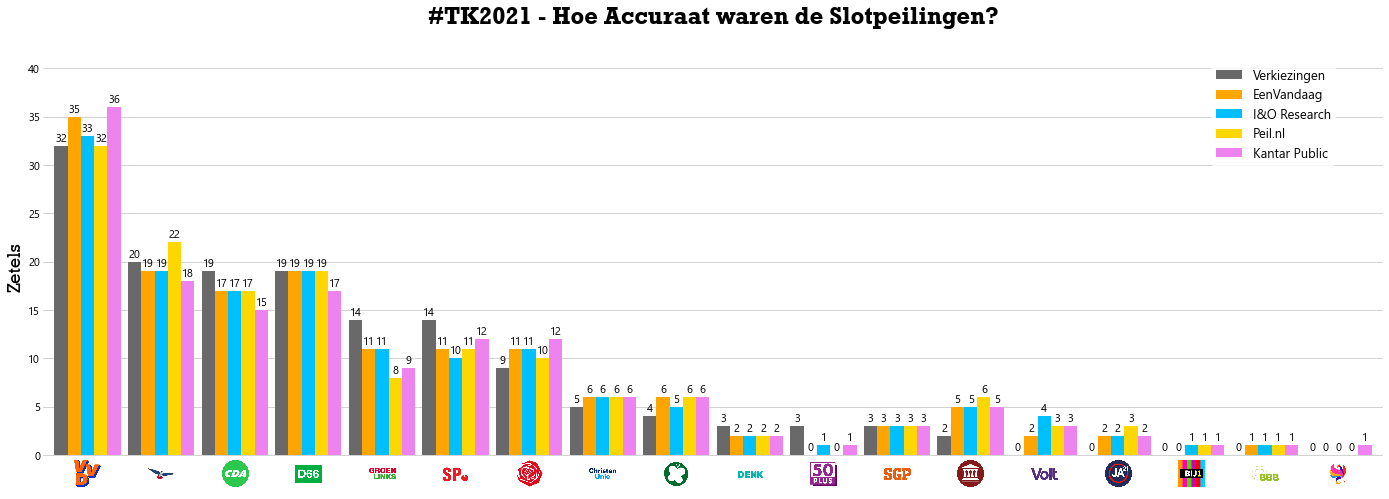

In [8]:
fig, ax = plt.subplots(figsize=(24,8))

# Bar Colors
color_list=['dimgrey', 'orange', 'deepskyblue', 'gold', 'violet']

# Plot bar plot
polls.plot.bar(width=.9, ax=ax, zorder=5, color=color_list)

# Title, labels and ticks
ax.set_title('#TK2021 - Hoe Accuraat waren de Slotpeilingen?', fontfamily='Rockwell')
ax.set_ylabel('Zetels', fontfamily='Rockwell')
plt.xticks([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# Grid and legend
ax.grid(axis='y', zorder=0)
ax.legend(bbox_to_anchor=(0.97, 0.98), fontsize=13)

# Plot party logos
for pos, party in enumerate(polls.index):
    plot_logo(pos, -2, f"logos/{party}.png", ax=ax, zoom=.12)

# Add value labels above bars
add_value_labels(ax)

# Limits
ax.set_ylim([-3, 42])
ax.set_xlim(-0.6, len(polls)-0.4)

# Save figure
fig.savefig('images/TK2021_polls.png', bbox_inches='tight')


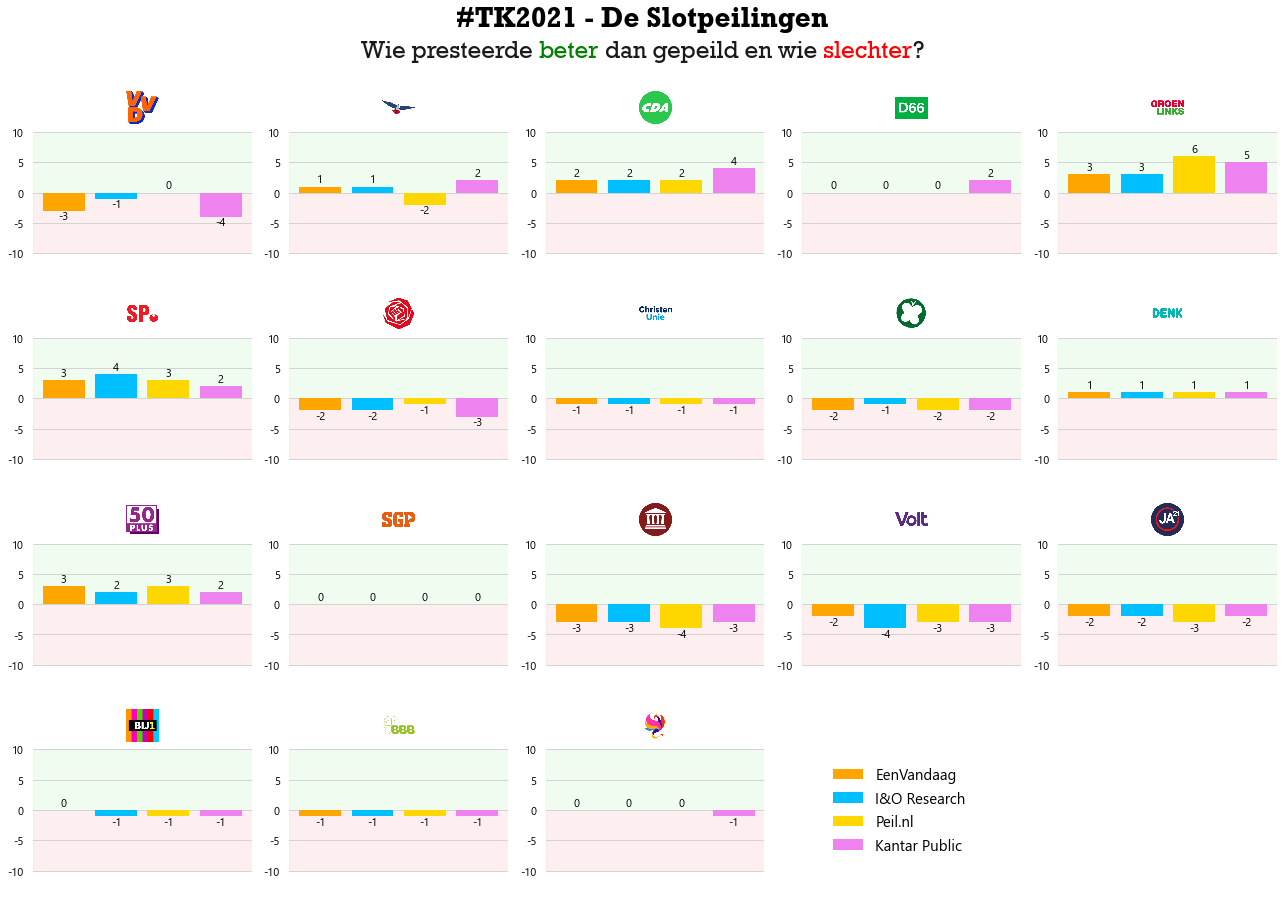

In [24]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(18,12), sharey=False)

for i, ax in enumerate(axes.flatten()):
    if i > (len(polls)-1):
        ax.axis('off')
        continue

    party_error = -(errors.iloc[i])

    for x, (label, height) in enumerate(party_error.items()):
        ax.bar(x=x, height=height, color=color_list[x+1], label=label)

    # Enable horizontal grid
    ax.grid(axis='y')

    # Set ticks
    ax.set_xticks([])
    ax.set_yticks(ticks=[-10, -5, 0, 5, 10])
    ax.set_yticklabels([-10, -5, 0, 5, 10], fontsize=11)

    # Plot party logos
    plot_logo(1.5, 14, f"logos/{party_error.name}.png", ax=ax, zoom=.15)

    # Add value labels above bars
    add_value_labels(ax)

# Titles
plt.suptitle('#TK2021 - De Slotpeilingen', y=1.05, fontsize=28, fontweight='bold', fontfamily='Rockwell')
fig_text(x=0.5, y=0.985,
        s='Wie presteerde <beter> dan gepeild en wie <slechter>?',
        color='k', highlight_colors = ['green', 'red'],  fontsize=24, fontfamily='Rockwell', ha='center')

for i in range(4):
    for j in range(5):
        if j in [3, 4] and i == 3:  # empty axes
            continue
        axes[i,j].axhspan(0, 10, alpha=0.12, color='lightgreen', zorder=0)
        axes[i,j].axhspan(0, -10, alpha=0.12, color='lightcoral', zorder=0)

# Plot legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.76, 0.185), fontsize=15)

# Set limits
plt.setp(axes, ylim=(-15, 15))
fig.tight_layout(h_pad=2, w_pad=1)

# Save figure
fig.savefig('images/TK2021_polling_error.png', dpi=300, bbox_inches='tight')